# Introduction

In this workshop, we will go through the steps of training and deploying a **network traffic classification model**.   

## Contents

1) [Setup](#setup)
2) [Basic Training](#basic_training)
3) [Register the Models](#register)
5) [Deploy and Predict](#deploy)
7) [Evaluate](#eval)

For training our model we will be using datasets <a href="https://registry.opendata.aws/cse-cic-ids2018/">CSE-CIC-IDS2018</a> by CIC and ISCX which are used for security testing and malware prevention.
These datasets include a huge amount of raw network traffic logs, plus pre-processed data where network connections have been reconstructed and  relevant features have been extracted using CICFlowMeter, a tool that outputs network connection features as CSV files. Each record is classified as benign traffic, or it can be malicious traffic, with a total number of 15 classes.

Starting from this featurized dataset, we have executed additional pre-processing for the purpose of this lab:
<ul>
    <li>Encoded class labels</li>
    <li>Replaced invalid string attribute values generated by CICFlowMeter (e.g. inf and Infinity)</li>
    <li>Executed one hot encoding of discrete attributes</li>
    <li>Remove invalid headers logged multiple times in the same CSV file</li>
    <li>Reduced the size of the featurized dataset to ~1.3GB (from ~6.3GB) to speed-up training, while making sure that all classes are well represented</li>
    <li>Executed stratified random split of the dataset into training (80%) and validation (20%) sets</li>
</ul>

Class are represented and have been encoded as follows (train + validation):


| Label                    | Encoded | N. records |
|:-------------------------|:-------:|-----------:|
| Benign                   |    0    |    1000000 |
| Bot                      |    1    |     200000 |
| DoS attacks-GoldenEye    |    2    |      40000 |
| DoS attacks-Slowloris    |    3    |      10000 |
| DDoS attacks-LOIC-HTTP   |    4    |     300000 |
| Infilteration            |    5    |     150000 |
| DDOS attack-LOIC-UDP     |    6    |       1730 |
| DDOS attack-HOIC         |    7    |     300000 |
| Brute Force -Web         |    8    |        611 |
| Brute Force -XSS         |    9    |        230 |
| SQL Injection            |   10    |         87 |
| DoS attacks-SlowHTTPTest |   11    |     100000 |
| DoS attacks-Hulk         |   12    |     250000 |
| FTP-BruteForce           |   13    |     150000 |
| SSH-Bruteforce           |   14    |     150000 |       

The final pre-processed dataset has been saved to a public Amazon S3 bucket for your convenience, and will represent the inputs to the training processes.
<a id='setup'></a>
### Let's get started!

First, we set some variables, including the AWS region we are working in, the IAM (Identity and Access Management) execution role of the notebook instance and the Amazon S3 bucket where we will store data, models, outputs, etc. We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [78]:
%pip install jsonlines
%pip install sagemaker --upgrade


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [88]:
import os
import time
import glob
import json
import jsonlines
import base64

import boto3
import sagemaker
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.sklearn.estimator import SKLearn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

pd.options.display.max_columns = 100

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()
prefix = 'sklearn-webtraffic'
os.environ["AWS_REGION"] = region

print(f'REGION:  {region}')
print(f'ROLE:    {role}')
print(f'BUCKET:  {bucket_name}')

# These are the clasifications that have been encoded as ints, we'll use these for analysis
class_list = ['Benign','Bot','DoS attacks-GoldenEye','DoS attacks-Slowloris','DDoS attacks-LOIC-HTTP','Infilteration','DDOS attack-LOIC-UDP','DDOS attack-HOIC','Brute Force-Web','Brute Force-XSS','SQL Injection','DoS attacks-SlowHTTPTest','DoS attacks-Hulk','FTP-BruteForce','SSH-Bruteforce']

REGION:  us-east-1
ROLE:    arn:aws:iam::431615879134:role/sagemaker-test-role
BUCKET:  sagemaker-us-east-1-431615879134


#### Now we can copy the dataset from the public Amazon S3 bucket to the Amazon SageMaker default bucket used in this workshop. To do this, we will leverage on the AWS Python SDK (boto3) as follows:

In [91]:
s3 = boto3.resource('s3')

source_bucket_name = "endtoendmlapp"
source_bucket_prefix = "aim362/data/"
source_bucket = s3.Bucket(source_bucket_name)

In [92]:
for s3_object in source_bucket.objects.filter(Prefix=source_bucket_prefix):
    copy_source = {
        'Bucket': source_bucket_name,
        'Key': s3_object.key
    }
    print('Copying {0} ...'.format(s3_object.key))
    s3.Bucket(bucket_name).copy(copy_source, prefix+'/data/'+s3_object.key.split('/')[-2]+'/'+s3_object.key.split('/')[-1].replace('.part','.csv'))
    
print(f'Data copy from source bucket, {source_bucket_name}/{source_bucket_prefix}, to destination bucket {bucket_name}/{prefix}/data/, complete!')

Copying aim362/data/train/0.part ...
Copying aim362/data/train/1.part ...
Copying aim362/data/train/2.part ...
Copying aim362/data/train/3.part ...
Copying aim362/data/train/4.part ...
Copying aim362/data/train/5.part ...
Copying aim362/data/train/6.part ...
Copying aim362/data/train/7.part ...
Copying aim362/data/train/8.part ...
Copying aim362/data/train/9.part ...
Copying aim362/data/val/0.part ...
Copying aim362/data/val/1.part ...
Copying aim362/data/val/2.part ...
Copying aim362/data/val/3.part ...
Copying aim362/data/val/4.part ...
Copying aim362/data/val/5.part ...
Copying aim362/data/val/6.part ...
Copying aim362/data/val/7.part ...
Copying aim362/data/val/8.part ...
Copying aim362/data/val/9.part ...
Data copy from source bucket, endtoendmlapp/aim362/data/, to destination bucket sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/, complete!


Let's download some of the data to the notebook to quickly explore the dataset structure:

# Data

In [93]:
train_file_path = 's3://' + bucket_name + '/' + prefix + '/data/train/0.csv'
val_file_path = 's3://' + bucket_name + '/' + prefix + '/data/val/'

print(train_file_path)
print(val_file_path)

s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/train/0.csv
s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/


In [94]:
!mkdir -p data/train/ data/val/
!aws s3 cp {train_file_path} data/train/ 
!aws s3 cp {val_file_path} data/val/ --recursive

download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/train/0.csv to data/train/0.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/1.csv to data/val/1.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/0.csv to data/val/0.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/2.csv to data/val/2.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/5.csv to data/val/5.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/3.csv to data/val/3.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/4.csv to data/val/4.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/6.csv to data/val/6.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/8.csv to data/val/8.csv
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/data/val/7.csv to data/val/7.

In [95]:
df = pd.read_csv('data/train/0.csv')
df

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,445,64443,5,4,373,172,140,0,74.600000,70.283711,133,0,43.000000,62.753486,8457.086107,139.658303,8.055375e+03,1.105582e+04,21474,3,64403,1.610075e+04,1.073215e+04,21537,3,64398,2.146600e+04,129.201393,21547,21317,0,0,0,0,112,92,77.587946,62.070357,0,140,54.500000,64.198044,4121.388889,0,0,0,1,0,0,0,0,0.0,60.555556,74.600000,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,5,373,4,172,8192,0,3,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
1,12,80,1527,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1309.757695,1.527000e+03,0.000000e+00,1527,1527,1527,1.527000e+03,0.000000e+00,1527,1527,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,1309.757695,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
2,7,80,5573,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,358.873138,5.573000e+03,0.000000e+00,5573,5573,5573,5.573000e+03,0.000000e+00,5573,5573,0,0.000000e+00,0.000000,0,0,0,0,0,0,40,0,358.873138,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
3,12,80,44934,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,44.509725,4.493400e+04,0.000000e+00,44934,44934,44934,4.493400e+04,0.000000e+00,44934,44934,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,44.509725,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
4,0,443,60108569,4,2,148,252,74,0,37.000000,42.723920,126,126,126.000000,0.000000,6.654625,0.099819,1.202171e+07,2.677679e+07,59921494,44882,60108569,2.003619e+07,3.454169e+07,59921494,93516,60013670,6.001367e+07,0.000000,60013670,60013670,1,0,0,0,80,40,0.066546,0.033273,0,126,67.714286,51.774235,2680.571429,0,1,0,0,1,0,0,0,0.0,79.000000,37.000000,126.000000,0.0,0.0,0.0,0.0,0.0,0.0,4,148,2,252,257,7010,1,20,93559.0,0.0,93559,93559,59921494.0,0.0,59921494,59921494,20,2,2018,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212208,14,22,298760,21,21,1912,2665,640,0,91.047619,139.679088,976,0,126.904762,263.574639,15319.989289,140.581068,7.286829e+03,2.230386e+04,122248,2,298722,1.493610e+04,3.049364e+04,122248,320,298752,1.493760e+04,33997.036726,126346,7,0,0,0,0,680,680,70.290534,70.290534,0,976,106.441860,207.291869,42969.919158,0,0,0,1,0,0,0,0,1.0,108.976190,91.047619,126.904762,0.0,0.0,0.0,0.0,0.0,0.0,21,1912,21,2665,26883,230,16,32,0.0,0.0,0,0,0.0,0.0,0,0,14,2,2018,2

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212213 entries, 0 to 212212
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Target             212213 non-null  int64  
 1   Dst Port           212213 non-null  int64  
 2   Flow Duration      212213 non-null  int64  
 3   Tot Fwd Pkts       212213 non-null  int64  
 4   Tot Bwd Pkts       212213 non-null  int64  
 5   TotLen Fwd Pkts    212213 non-null  int64  
 6   TotLen Bwd Pkts    212213 non-null  int64  
 7   Fwd Pkt Len Max    212213 non-null  int64  
 8   Fwd Pkt Len Min    212213 non-null  int64  
 9   Fwd Pkt Len Mean   212213 non-null  float64
 10  Fwd Pkt Len Std    212213 non-null  float64
 11  Bwd Pkt Len Max    212213 non-null  int64  
 12  Bwd Pkt Len Min    212213 non-null  int64  
 13  Bwd Pkt Len Mean   212213 non-null  float64
 14  Bwd Pkt Len Std    212213 non-null  float64
 15  Flow Byts/s        211574 non-null  float64
 16  Fl

In [97]:
val_df = pd.read_csv("./data/val/3.csv")

In [98]:
val_df

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,4,80,41741569,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,4.791387e-02,4.170000e+07,0.000000,41700000,41700000,41700000,4.170000e+07,0.000000,41700000,41700000,0,0.000000,0.000000,0,0,0,0,0,0,40,0,0.047914,0.000000,0,0,0.0000,0.000000,0.0000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,2049,-1,0,20,0.0,0.0,0,0,41700000.0,0.0,41700000,41700000,20,2,2018,1,0,1,0
1,4,80,1267608,3,4,20,964,20,0,6.666667,11.547005,964,0,241.000000,482.000000,776.265218,5.522212e+00,2.112680e+05,517266.616200,1267134,1,447,2.235000e+02,314.662518,446,1,1267602,422534.000000,731445.086800,1267134,22,0,0,0,0,72,92,2.366662,3.155550,0,964,123.0000,339.887376,115523.4286,0,0,1,1,0,0,0,1,1.0,140.571429,6.666667,241.000000,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
2,13,21,1,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000,1,1,0,0.000000e+00,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,0,40,20,1000000.000000,1000000.000000,0,0,0.0000,0.000000,0.0000,0,0,0,1,0,0,0,0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,26883,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,14,2,2018,2,0,1,0
3,13,21,1,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000,1,1,0,0.000000e+00,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,0,40,20,1000000.000000,1000000.000000,0,0,0.0000,0.000000,0.0000,0,0,0,1,0,0,0,0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,26883,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,14,2,2018,2,0,1,0
4,0,3389,1719730,8,7,1128,1581,661,0,141.000000,222.623321,1173,0,225.857143,430.098604,1575.247277,8.722299e+00,1.228379e+05,245415.138688,953191,4,1719730,2.456757e+05,390340.649099,1125099,4,1601462,266910.333333,336841.974375,953191,113295,0,0,0,0,172,152,4.651893,4.070406,0,1173,169.3125,317.731274,100953.1625,0,0,1,1,0,0,0,1,0.0,180.600000,141.000000,225.857143,0.0,0.0,0.0,0.0,0.0,0.0,8,1128,7,1581,8192,62872,5,20,0.0,0.0,0,0,0.0,0.0,0,0,28,2,2018,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53049,7,80,1777,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1.125492e+03,1.777000e+03,0.000000,1777,1777,1777,1.777000e+03,0.000000,1777,1777,0,0.000000,0.000000,0,0,0,0,0,0,40,0,1125.492403,0.000000,0,0,0.0000,0.000000,0.0000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
53050,4,80,960774,3,4,20,964,20,0,6.666667,11.547005,964,0,241.000000,482.000000,1024.174260,7.285792e+00,1.60129

<a id='basic_training'></a>
# Training

We will execute the training using a Sklearn algorithm.  This approach is known as script mode if you need to have greater customization of the training process.  


In [99]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/train'.format(bucket_name, prefix), content_type='text/csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/val'.format(bucket_name, prefix), content_type='text/csv')

## Model - Hist Gradient Boosting

In [100]:
output_path = f's3://{bucket_name}/{prefix}/output/'

FRAMEWORK_VERSION = "1.0-1"

estimator = SKLearn(
    entry_point="histgradientboost.py",
    source_dir='./code/',
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="hgbc-scikit",
    metric_definitions=[
        {"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"},
        {"Name": "WeightedF1", "Regex": "Weighted F1 Score is: ([0-9.]+).*$"}
    ],
    output_path=output_path,
    hyperparameters={
        "learningrate": 0.1,
        "maxiter": 90
    }
)

In [101]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: hgbc-scikit-2023-03-08-14-30-25-913


2023-03-08 14:30:26 Starting - Starting the training job...
2023-03-08 14:30:46 Starting - Preparing the instances for training......
2023-03-08 14:31:48 Downloading - Downloading input data...
2023-03-08 14:32:20 Training - Training image download completed. Training in progress...2023-03-08 14:32:34,738 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-03-08 14:32:34,740 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-08 14:32:34,748 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-03-08 14:32:34,937 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-08 14:32:34,947 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-08 14:32:34,957 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-08 14:32:34,965 sagemaker-training-toolkit INFO     Invoking user scri

<a id='deploy'></a>
## Deploy!

Let's deploy the first model to a production real time SageMaker endpoint.  This is an HTTPS endpoint that is active 24 hours per day, 7 days per week.  It will stay active until we delete it.  Here we add a serializer to convert the incoming inference request to CSV.  We use a CSV serializer since the XGBoost Algorithm used in model 1 can accept data in 'text/libsvm' or 'text/csv' formats.  You can find additional details on the input/output interface in the [XGBoost Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)

In [102]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_s3 = f's3://{bucket_name}/{prefix}/datacapture/'

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_s3
)

In [103]:
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.2xlarge', data_capture_config=data_capture_config)

INFO:sagemaker:Creating model with name: hgbc-scikit-2023-03-08-14-34-14-154
INFO:sagemaker:Creating endpoint-config with name hgbc-scikit-2023-03-08-14-34-14-154
INFO:sagemaker:Creating endpoint with name hgbc-scikit-2023-03-08-14-34-14-154


-----!

In [104]:
predictor.endpoint_name

'hgbc-scikit-2023-03-08-14-34-14-154'

## Predict

Here we use the sagemaker predictor object to call our deployed instance. We send a set of hardcoded values that should result in an inference of 4, DDoS attacks-LOIC-HTTP, and that is the predicted value.

In [105]:
# single prediction
# We expect 4 - DDoS attacks-LOIC-HTTP as the predicted class.
test_values = np.array([80,1056736,3,4,20,964,20,0,6.666666667,11.54700538,964,0,241.0,482.0,931.1691850999999,6.6241710320000005,176122.6667,431204.4454,1056315,2,394,197.0,275.77164469999997,392,2,1056733,352244.3333,609743.1115,1056315,24,0,0,0,0,72,92,2.8389304419999997,3.78524059,0,964,123.0,339.8873763,115523.4286,0,0,1,1,0,0,0,1,1.0,140.5714286,6.666666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0]).reshape(-1, 1).T

In [106]:
result = predictor.predict(test_values)
print(result)

[4]


## Simulate Production Traffic

We will now simulate the production traffic.  We will loop over the production data.  In a real production use case you won't need to do this since actual production data will be flowing to the production endpoint.  

In [107]:
data = val_df.to_numpy()

In [108]:
import numpy as np

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        predictions.extend(predictor.predict(array))

    return predictions

In [109]:
preds = predict(data[:,1:])

In [110]:
!aws s3 ls {data_capture_s3}

                           PRE hgbc-scikit-2023-03-08-14-34-14-154/


#### Now let's copy the captured data from s3 to the local EFS connected to SageMaker Studio

In [111]:
!mkdir ./data/datacapture/

In [113]:
!aws s3 cp {data_capture_s3} ./data/datacapture/  --recursive

download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/datacapture/hgbc-scikit-2023-03-08-14-34-14-154/AllTraffic/2023/03/08/14/40-59-660-fc414a82-4011-43fd-8bed-dd84ea38d578.jsonl to data/datacapture/hgbc-scikit-2023-03-08-14-34-14-154/AllTraffic/2023/03/08/14/40-59-660-fc414a82-4011-43fd-8bed-dd84ea38d578.jsonl
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/datacapture/hgbc-scikit-2023-03-08-14-34-14-154/AllTraffic/2023/03/08/14/40-57-573-0ff938cf-4671-41be-9f52-1580ce08c9c0.jsonl to data/datacapture/hgbc-scikit-2023-03-08-14-34-14-154/AllTraffic/2023/03/08/14/40-57-573-0ff938cf-4671-41be-9f52-1580ce08c9c0.jsonl
download: s3://sagemaker-us-east-1-431615879134/sklearn-webtraffic/datacapture/hgbc-scikit-2023-03-08-14-34-14-154/AllTraffic/2023/03/08/14/40-51-617-7fe1f465-df75-43fa-a5ec-af3b1dc8c204.jsonl to data/datacapture/hgbc-scikit-2023-03-08-14-34-14-154/AllTraffic/2023/03/08/14/40-51-617-7fe1f465-df75-43fa-a5ec-af3b1dc8c204.jsonl
download: s3://sage

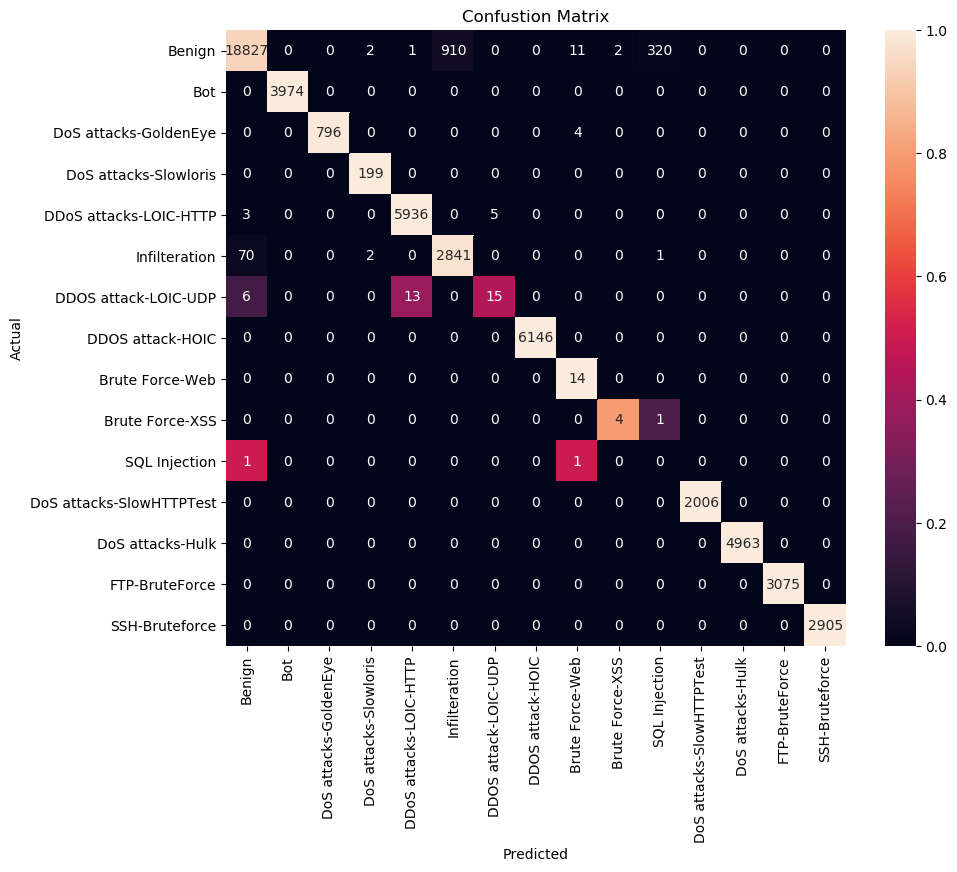

In [121]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(data[:,0],preds)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confustion Matrix')
plt.show()

In [120]:
print(classification_report(data[:,0],preds,target_names=class_list))

                          precision    recall  f1-score   support

                  Benign       1.00      0.94      0.97     20073
                     Bot       1.00      1.00      1.00      3974
   DoS attacks-GoldenEye       1.00      0.99      1.00       800
   DoS attacks-Slowloris       0.98      1.00      0.99       199
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00      5944
           Infilteration       0.76      0.97      0.85      2914
    DDOS attack-LOIC-UDP       0.75      0.44      0.56        34
        DDOS attack-HOIC       1.00      1.00      1.00      6146
         Brute Force-Web       0.47      1.00      0.64        14
         Brute Force-XSS       0.67      0.80      0.73         5
           SQL Injection       0.00      0.00      0.00         2
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      2006
        DoS attacks-Hulk       1.00      1.00      1.00      4963
          FTP-BruteForce       1.00      1.00      1.00      3075
         

##### Finally, let's gracefully stop the deployed endpoint.

## Clean Up

In [73]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: hgbc-scikit-2023-03-08-12-14-31-737
INFO:sagemaker:Deleting endpoint with name: hgbc-scikit-2023-03-08-12-14-31-737


# References

* A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018) - https://registry.opendata.aws/cse-cic-ids2018/
* AIM362 - Re:Invent 2019 SageMaker Debugger and Model Monitor - https://github.com/aws-samples/reinvent2019-aim362-sagemaker-debugger-model-monitor